# Introduction of Second Notebook

This notebook is the Second Notebook of the 2 part series of our CS3244 Project. This notebook mainly covers the Data Preprocessing steps that was used to prepare the data for model fitting and the testing of multiple Machine Learning Models to do our Resale Flat Price Predictions.

# Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from scipy import stats

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid, train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from lightgbm import LGBMRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("df_train.csv", index_col = 0)
df_test = pd.read_csv("df_test.csv", index_col = 0)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160858 entries, 0 to 160857
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   month                                  160858 non-null  object 
 1   town                                   160858 non-null  object 
 2   flat_type                              160858 non-null  object 
 3   block                                  160858 non-null  object 
 4   street_name                            160858 non-null  object 
 5   storey_range                           160858 non-null  object 
 6   floor_area_sqm                         160858 non-null  float64
 7   flat_model                             160858 non-null  object 
 8   lease_commence_date                    160858 non-null  int64  
 9   remaining_lease                        160858 non-null  object 
 10  resale_price                           160858 non-null  float

In [ ]:
def drop_cols(df):
    # Drop unnecessary columns
    df.drop(['bldg_contract_town', 'latitude', 'longitude', 'lease_commence_date'], axis=1, inplace=True)
    return df

In [ ]:
df_train_filtered = drop_cols(df_train)
df_test_filtered = drop_cols(df_test)

In [ ]:
df_train['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

## Validating if Categorical Columns in Test Set are found in Train Set

In [ ]:
# Initialize a dictionary to store categories only in the test set along with their corresponding column names
categories_only_in_test = {}

# Loop through each categorical column
for column_name in df_train_filtered.select_dtypes(include='object').columns:
    # Get unique categories in the train set
    train_categories = set(df_train_filtered[column_name])

    # Get unique categories in the test set
    test_categories = set(df_test_filtered[column_name])

    # Find categories present in the test set but not in the train set
    categories_only_in_test[column_name] = test_categories - train_categories

# Print categories in the test set that do not belong to the train set along with their corresponding column names
print("Categories in test set that do not belong to train set:")
for column_name, categories in categories_only_in_test.items():
    print("Column:", column_name)
    print("Categories:", categories)
    print("\n")

Categories in test set that do not belong to train set:
Column: month
Categories: {'2024-02-01', '2023-10-01', '2023-11-01', '2024-03-01', '2024-01-01', '2023-12-01', '2023-09-01'}


Column: town
Categories: set()


Column: flat_type
Categories: set()


Column: block
Categories: {'182A', '996C', '606A', '462A', '182B', '460A', '438C', '606D', '605D', '461C', '996B', '605A', '462C', '605B', '323D', '605C', '995A', '461B', '991B', '860B', '999B', '437A', '995C', '462B', '995B', '606C', '462D', '998A', '606B', '996A'}


Column: street_name
Categories: {'YISHUN ST 43', 'TAMPINES ST 61'}


Column: storey_range
Categories: set()


Column: flat_model
Categories: set()


Column: remaining_lease
Categories: {'41 years 09 months', '42 years 02 months', '42 years 04 months', '41 years 11 months', '42 years 03 months', '42 years 01 month', '42 years'}


Column: closest_mrt
Categories: set()


Column: residential
Categories: set()


Column: commercial
Categories: set()


Column: market_hawker
Categ

## Storey Range

We observe that the storey range values are categorical data. Converting them into numerical data by assigning the median value of each range can provide a more meaningful representation. For instance, for the range '10 TO 12', the median value would be 11. Similarly, '01 TO 03' would be represented as 2, '04 TO 06' as 5, and so forth. This transformation enables us to utilize the ordinal nature of the storey ranges in our analysis effectively

In [ ]:
df_train_filtered['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

In [ ]:
def get_median_storey_range(df):
    df['storey_range'] = df['storey_range'].str.split(' TO ').apply(lambda x: (int(x[1]) + int(x[0])) / 2)
    return df

In [ ]:
df_train_preprocessed = get_median_storey_range(df_train_filtered)
df_test_preprocessed = get_median_storey_range(df_test_filtered)

## Mapping Y/N columns to Boolean

In [ ]:
# Encode columns with 'Y'/'N' values
def map_yn_to_bool(df):
    yn_cols = ['residential', 'commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark', 'precinct_pavilion']

    # Map to True / False
    for col in yn_cols:
        df[col] = df[col].replace({'Y': True, 'N': False})

    return df

In [ ]:
df_train_preprocessed = map_yn_to_bool(df_train_preprocessed)
df_test_preprocessed = map_yn_to_bool(df_test_preprocessed)

## Converting the least commencement date to remaining lifespan of house

As the current remaining_lease column format is in categorical form, we will be converting it into a the remaining lifespan of the flat in months so that we can fit it as a numerical column.

In [ ]:
df_train_filtered['remaining_lease'].unique()[0]

'61 years 04 months'

In [ ]:
def convert_remaining_lease(df):
    def convert(x):
        parts = x.split()
        years = int(parts[0])
        months = int(parts[2]) if 'months' in x else 0
        total_months = years * 12 + months
        return total_months

    df['remaining_lease'] = df['remaining_lease'].apply(convert)

    return df

In [ ]:
df_train_preprocessed = convert_remaining_lease(df_train_preprocessed)
df_test_preprocessed = convert_remaining_lease(df_test_preprocessed)

## Converting transaction date into Year and Month Column

The current format of the date of transactions makes it difficult for us to process it in our model. Hence we will be splitting the transaction date into a Year column and Month column.

In [ ]:
df_train_filtered['month'].unique()

array(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
       '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-11-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-

In [ ]:
def convert_transaction_date(df):
    date_of_transaction = pd.to_datetime(df['month'])

    # Create Year and Month Columns
    df['year'] = date_of_transaction.dt.year
    df['month_numeric'] = date_of_transaction.dt.month

    # Drop original transaction date column
    df.drop('month', axis = 1, inplace = True)
    return df

In [ ]:
df_train_preprocessed = convert_transaction_date(df_train_preprocessed)
df_test_preprocessed = convert_transaction_date(df_test_preprocessed)

In [ ]:
df_train_preprocessed.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,shortest_distance_to_closest_mrt (km),...,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,is_elite_closest_pri_sch,is_elite_closest_sec_sch,is_elite_closest_mixed_sch,year,month_numeric
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,11.0,44.0,Improved,736,232000.0,1.007304,...,False,False,False,False,220,False,False,True,2017,1
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,2.0,67.0,New Generation,727,250000.0,1.271398,...,False,False,False,False,122,False,False,True,2017,1
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,2.0,67.0,New Generation,749,262000.0,1.069720,...,False,False,False,False,150,False,False,True,2017,1
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,5.0,68.0,New Generation,744,265000.0,0.946884,...,False,False,False,False,206,False,False,True,2017,1
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,2.0,67.0,New Generation,749,265000.0,1.092577,...,False,True,False,False,152,False,False,True,2017,1


## Dropping street and block columns

After applying the nunique() function, it is evident that both the 'block' and 'street_name' columns contain a large number of distinct values, indicating significant sparsity. Considering that the building information is already well-represented by other features in the dataset, maintaining these columns would likely introduce unnecessary complexity. Therefore, to streamline the dataset and reduce dimensionality, we have decided to drop the 'block' and 'street_name' columns.

In [ ]:
df_train_preprocessed.nunique()

town                                       26
flat_type                                   7
block                                    2673
street_name                               565
storey_range                               17
floor_area_sqm                            170
flat_model                                 21
remaining_lease                           608
resale_price                             3574
shortest_distance_to_closest_mrt (km)    9475
closest_mrt                               125
max_floor_lvl                              42
year_completed                             60
residential                                 1
commercial                                  2
market_hawker                               2
miscellaneous                               2
multistorey_carpark                         2
precinct_pavilion                           2
total_dwelling_units                      327
is_elite_closest_pri_sch                    2
is_elite_closest_sec_sch          

In [ ]:
df_train_preprocessed = df_train_preprocessed.drop(['street_name', 'block'], axis = 1)
df_test_preprocessed = df_test_preprocessed.drop(['street_name', 'block'], axis = 1)

## Flat Model

During our categorical data encoding, we actually found some categories '2-room' and '3Gen' that were not originally in the train set. For these data points, we will be imputing their values with the most common flat model - Model A.

In [ ]:
train_categories = set(df_train_preprocessed['flat_model'])

test_categories = set(df_test_preprocessed['flat_model'])

categories_only_in_test = test_categories - train_categories

print(df_train_preprocessed['flat_model'].value_counts())
print("Categories in test set that do not belong to train set:", categories_only_in_test)

flat_model
Model A                   54895
Improved                  39878
New Generation            20134
Premium Apartment         18392
Simplified                 6255
Apartment                  6125
Maisonette                 4645
Standard                   4491
DBSS                       2813
Model A2                   1846
Model A-Maisonette          293
Adjoined flat               286
Type S1                     285
Type S2                     153
Premium Apartment Loft       96
Terrace                      90
Multi Generation             73
2-room                       55
Improved-Maisonette          24
3Gen                         15
Premium Maisonette           14
Name: count, dtype: int64
Categories in test set that do not belong to train set: set()


In [ ]:
# Filter to '2-room' and '3Gen'
filtered_rows = df_test_preprocessed[df_test_preprocessed['flat_model'].isin(['2-room', '3Gen'])]

# Impute 'flat_model' of the filtered rows to be 'Model A'
df_test_preprocessed.loc[filtered_rows.index, 'flat_model'] = 'Model A'

## closest_mrt

Earlier, we found that some of the closest mrt stations in the test were not actually found in the train set. For these stations, a quick google search shows that they are LRT stations that are found around the Punggol estate. For ease of ensuring that our encoding process runs smoothly, we will be imputing their values as "Punggol" MRT Station.

In [ ]:
df_train_preprocessed['closest_mrt'].unique()

array(['Ang Mo Kio', 'Yio Chu Kang', 'Bedok Reservoir', 'Bedok',
       'Tanah Merah', 'Kaki Bukit', 'Bedok North', 'Kembangan',
       'Marymount', 'Bishan', 'Bukit Gombak', 'Bukit Batok',
       'Tiong Bahru', 'Telok Blangah', 'HarbourFront', 'Queenstown',
       'Redhill', 'Labrador Park', 'Pending', 'Bangkit', 'Segar',
       'Jelapang', 'Petir', 'Fajar', 'Senja', 'Beauty World',
       'Farrer Road', 'Chinatown', 'Jalan Besar', 'Bencoolen',
       'Tanjong Pagar', 'Bugis', 'Bras Basah', 'Outram Park', 'Teck Whye',
       'Keat Hong', 'South View', 'Yew Tee', 'Choa Chu Kang', 'Phoenix',
       'Clementi', 'Mattar', 'MacPherson', 'Tai Seng', 'Eunos', 'Ubi',
       'Paya Lebar', 'Dakota', 'Aljunied', 'Geylang Bahru', 'Mountbatten',
       'Tongkang', 'Kovan', 'Hougang', 'Serangoon', 'Bartley', 'Buangkok',
       'Jurong East', 'Chinese Garden', 'Pioneer', 'Boon Lay', 'Lakeside',
       'King Albert Park', 'Boon Keng', 'Farrer Park', 'Hillview',
       'Kallang', 'Lavender', 'Bendemee

In [ ]:
# Filter to '2-room' and '3Gen'
filtered_rows = df_test_preprocessed[df_test_preprocessed['closest_mrt'].isin(['Kupang', 'Nibong', 'Thanggam', 'Sumang'])]

# Impute 'flat_model' of the filtered rows to be 'Model A'
df_test_preprocessed.loc[filtered_rows.index, 'closest_mrt'] = 'Punggol'

## Viewing the final preprocessed dataset

In [ ]:
df_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160858 entries, 0 to 160857
Data columns (total 23 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   town                                   160858 non-null  object 
 1   flat_type                              160858 non-null  object 
 2   storey_range                           160858 non-null  float64
 3   floor_area_sqm                         160858 non-null  float64
 4   flat_model                             160858 non-null  object 
 5   remaining_lease                        160858 non-null  int64  
 6   resale_price                           160858 non-null  float64
 7   shortest_distance_to_closest_mrt (km)  160858 non-null  float64
 8   closest_mrt                            160858 non-null  object 
 9   max_floor_lvl                          160858 non-null  int64  
 10  year_completed                         160858 non-null  int64

In [ ]:
df_test_preprocessed.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,shortest_distance_to_closest_mrt (km),closest_mrt,max_floor_lvl,...,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,total_dwelling_units,is_elite_closest_pri_sch,is_elite_closest_sec_sch,is_elite_closest_mixed_sch,year,month_numeric
160858,ANG MO KIO,2 ROOM,2.0,44.0,Improved,640,282000.0,0.423595,Ang Mo Kio,12,...,False,True,False,False,242,False,False,True,2023,9
160859,ANG MO KIO,2 ROOM,5.0,45.0,Improved,737,300000.0,1.223815,Yio Chu Kang,10,...,False,True,False,False,178,False,False,True,2023,9
160860,ANG MO KIO,3 ROOM,5.0,73.0,New Generation,620,370888.0,0.994162,Ang Mo Kio,10,...,False,False,False,False,144,False,False,True,2023,9
160861,ANG MO KIO,3 ROOM,2.0,68.0,New Generation,679,360000.0,0.854823,Ang Mo Kio,12,...,False,False,False,False,195,False,False,True,2023,9
160862,ANG MO KIO,3 ROOM,8.0,70.0,Model A,1056,570000.0,0.696736,Ang Mo Kio,21,...,False,False,False,False,230,False,False,True,2023,9


In [ ]:
df_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14035 entries, 160858 to 174892
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   town                                   14035 non-null  object 
 1   flat_type                              14035 non-null  object 
 2   storey_range                           14035 non-null  float64
 3   floor_area_sqm                         14035 non-null  float64
 4   flat_model                             14035 non-null  object 
 5   remaining_lease                        14035 non-null  int64  
 6   resale_price                           14035 non-null  float64
 7   shortest_distance_to_closest_mrt (km)  14035 non-null  float64
 8   closest_mrt                            14035 non-null  object 
 9   max_floor_lvl                          14035 non-null  int64  
 10  year_completed                         14035 non-null  int64  
 11  r

# Model Fitting

In this section, we will be attempting to fit our data into several models, ranging from basic models like Linear Regression to Gradient Boosting Models like Light GBM. We will be evaluating the results across all models and find out which is the best performing model.

## Train Test Split

In [ ]:
# Train Test Split
X_train = df_train_preprocessed.drop(['resale_price'], axis=1)
y_train = df_train_preprocessed['resale_price']

X_test = df_test_preprocessed.drop(['resale_price'], axis=1)
y_test = df_test_preprocessed['resale_price']

## Feature encoding

In [ ]:
# Define function to split column types
def splitColumnTypes(df):
    cate_cols = []
    num_cols = []
    dtypes = df.dtypes
    for col, dtype in dtypes.items():
        if dtype == 'object':
            cate_cols.append(col)
        else:
            num_cols.append(col)
    return cate_cols, num_cols

# Split column types
cate_cols, num_cols = splitColumnTypes(X_train)

# Define transformer
transformer = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols),\
                                              ('cat', OneHotEncoder(), cate_cols)])

pipeline = Pipeline(steps=[('preprocessor', transformer)])

# Use the fitted Pipeline to transform Test Data - Prevent Data Leakage
X_train_encoded = pipeline.fit_transform(X_train)
X_test_encoded = pipeline.transform(X_test)

In [ ]:
print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_encoded: (160858, 197)
Shape of X_test_encoded: (14035, 197)
Shape of y_train: (160858,)
Shape of y_test: (14035,)


We retrieve the encoded column names.

In [ ]:
encoded_column_names = transformer.transformers_[1][1].get_feature_names_out(input_features=cate_cols)

all_column_names = list(num_cols) + list(encoded_column_names)

## Evaluation Metrics

In [ ]:
collection_of_model_results = {}

We define the following Evaluation Metrics for our Regression Task.

Mean Absolute Error: Measures the average of the absolute differences between predicted and actual prices.

R-Squared Score: Measures the proportion of the variance explained by the model.

Root Mean Squared Error: Measures the average price distances (after punishing heavily mispredictions)

Mean Absolute Percentage Error: Measures the average percentage difference between predicted and actual prices of flats

In [ ]:
def evaluate_results(model_name, y_test, y_pred):
    results = {}
    results[model_name] = {
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'R-squared score': r2_score(y_test, y_pred),
        'Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Mean Absolute Percentage Error': mean_absolute_percentage_error(y_test, y_pred) * 100
    }

    print(f'{model_name}: Mean Absolute Error:', results[model_name]['Mean Absolute Error'])
    print(f'{model_name}: R-squared score:', results[model_name]['R-squared score'])
    print(f'{model_name}: Root Mean Squared Error:', results[model_name]['Root Mean Squared Error'])
    print(f'{model_name}: Mean Absolute Percentage Error:', results[model_name]['Mean Absolute Percentage Error'], "%")

    return results

In [ ]:
def plot_prediction_results(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.title('Predicted Labels against Actual Labels')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')

## Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_encoded, y_train)
y_pred_lr = lr.predict(X_test_encoded)

In [ ]:
lr_results = evaluate_results("Linear Regression", y_test, y_pred_lr)
collection_of_model_results['Linear Regression'] = lr_results

Linear Regression: Mean Absolute Error: 48455.090760864936
Linear Regression: R-squared score: 0.8645750583529281
Linear Regression: Root Mean Squared Error: 65433.19863576084
Linear Regression: Mean Absolute Percentage Error: 8.253609793219747 %


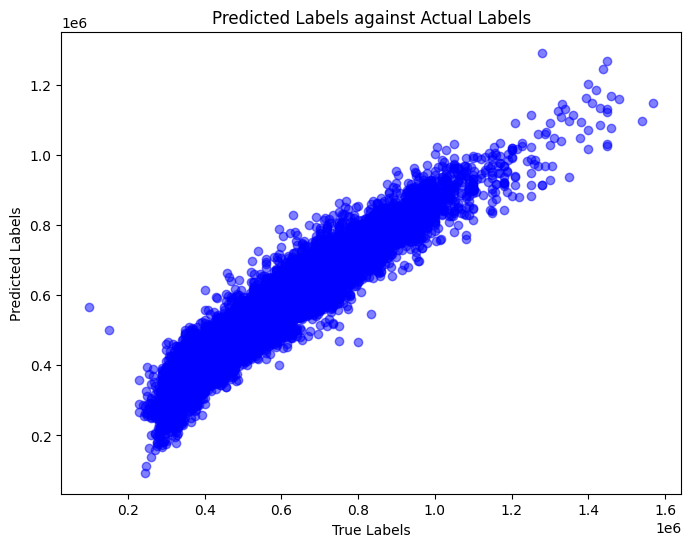

In [ ]:
plot_prediction_results(y_test, y_pred_lr)

## Linear Regression with Regularisation

In this section, we attempt to fit our encoded dataset into Linear Regression models with L2 and L1 Regression. Since our encoded dataset contains over 190 features, regularisation may have a big role in attaining higher test scores as compared to the baseline Regression Models.

### L2 Regularisation (Ridge)

In [ ]:
l2_lr = RidgeCV(cv = 5)
l2_lr.fit(X_train_encoded, y_train)

RidgeCV(cv=5)

The best L2 Regularisation Parameter is 0.1.

In [ ]:
print("Best alpha parameter:", l2_lr.alpha_)
print("Best alpha cv score:", l2_lr.best_score_)

Best alpha parameter: 0.1
Best alpha cv score: 0.818291979982052


In [ ]:
y_pred_ridge = l2_lr.predict(X_test_encoded)

In [ ]:
l2_reg_results = evaluate_results("L2 Linear Regression (Ridge)", y_test, y_pred_ridge)
collection_of_model_results['L2 Linear Regression (Ridge)'] = l2_reg_results

L2 Linear Regression (Ridge): Mean Absolute Error: 48476.53629754607
L2 Linear Regression (Ridge): R-squared score: 0.864473247747449
L2 Linear Regression (Ridge): Root Mean Squared Error: 65457.78990343943
L2 Linear Regression (Ridge): Mean Absolute Percentage Error: 8.252991480226274 %


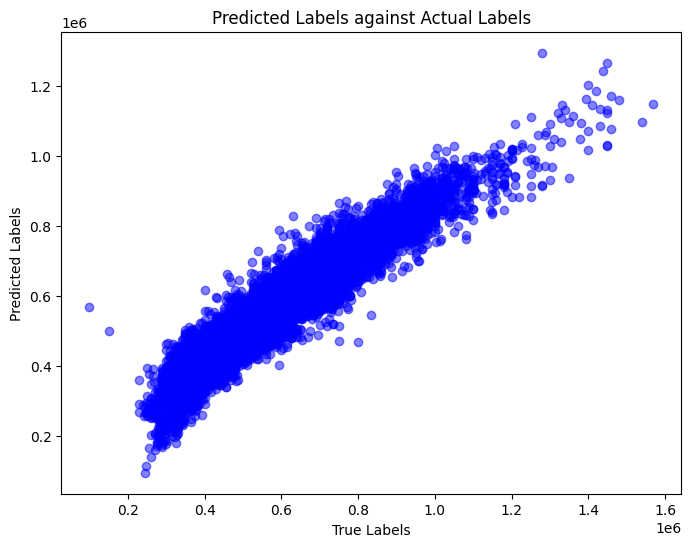

In [ ]:
plot_prediction_results(y_test, y_pred_ridge)

### Lasso Model L1

It appears that the Lasso Regression model failed to converge during its cross validation.

In [ ]:
l1_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], max_iter = 200)
l1_cv.fit(X_train_encoded, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39853496018526.09, tolerance: 373818057061.2144
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105715652602153.16, tolerance: 373818057061.2144
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159408997751981.06, tolerance: 373818057061.2144
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: Conver

LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], max_iter=200)

In [ ]:
print("Best alpha parameter:", l1_cv.alpha_)

Best alpha parameter: 0.01


In [ ]:
y_pred_lasso = l1_cv.predict(X_test_encoded)
l1_reg_results = evaluate_results("L1 Linear Regression (Lasso)", y_test, y_pred_lasso)
collection_of_model_results['L1 Linear Regression (Lasso)'] = l1_reg_results

L1 Linear Regression (Lasso): Mean Absolute Error: 48474.960338679964
L1 Linear Regression (Lasso): R-squared score: 0.8645172054277863
L1 Linear Regression (Lasso): Root Mean Squared Error: 65447.17352729639
L1 Linear Regression (Lasso): Mean Absolute Percentage Error: 8.25331091243294 %


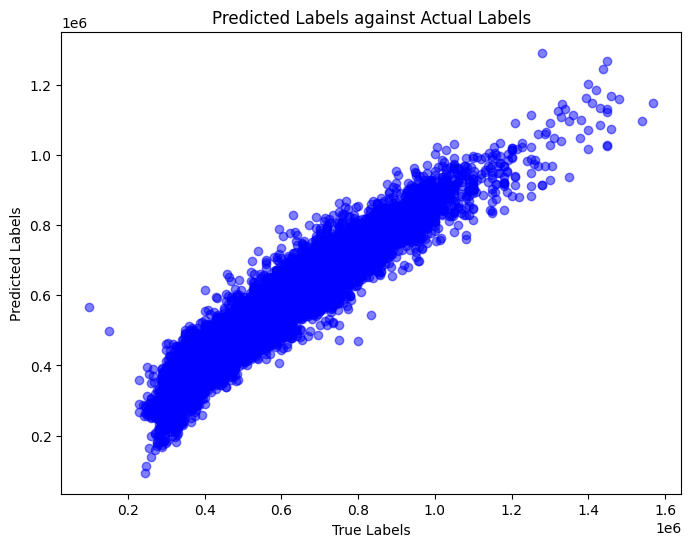

In [ ]:
plot_prediction_results(y_test, y_pred_lasso)

### ElasticNet Model (L1 + L2 Regularisation)

After fitting the data into the individual L1 and L2 Regression Models, we would want to see if using the ElasticNet Model (combined L1 and L2 Regularisation) would achieve better results. We also want to analyse what is the best L1-Ratio that achieves the highest CV score. The l1_ratio mixing parameter ranges from 0 to 1. When l1_ratio is 0, the penalty applied is an L2 penalty. Conversely, when l1_ratio is 1, it corresponds to an L1 penalty. For values of l1_ratio between 0 and 1 exclusive, the penalty combines elements of both L1 and L2 penalties.

According to sklearn's documenatation on ElasticNet, a good choice of list of values for l1_ratio is often to put more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge).

In [ ]:
elastic_cv = ElasticNetCV(cv=2, alphas = [0.1, 0.5, 1.0, 5.0, 10, 100],
                          l1_ratio = [0.9, 0.95, 0.97],
                          verbose = 2)

elastic_cv.fit(X_train_encoded, y_train)

Path: 000 out of 006
Path: 001 out of 006
Path: 002 out of 006
Path: 003 out of 006
Path: 004 out of 006
Path: 005 out of 006
Path: 000 out of 006
Path: 001 out of 006
Path: 002 out of 006
Path: 003 out of 006
Path: 004 out of 006
Path: 005 out of 006
Path: 000 out of 006
Path: 001 out of 006
Path: 002 out of 006
Path: 003 out of 006
Path: 004 out of 006
Path: 005 out of 006
Path: 000 out of 006
Path: 001 out of 006
Path: 002 out of 006
Path: 003 out of 006
Path: 004 out of 006
Path: 005 out of 006
Path: 000 out of 006
Path: 001 out of 006
Path: 002 out of 006
Path: 003 out of 006
Path: 004 out of 006
Path: 005 out of 006
Path: 000 out of 006
Path: 001 out of 006
Path: 002 out of 006
Path: 003 out of 006
Path: 004 out of 006
Path: 005 out of 006


ElasticNetCV(alphas=[0.1, 0.5, 1.0, 5.0, 10, 100], cv=2,
             l1_ratio=[0.9, 0.95, 0.97], verbose=2)

In [ ]:
alpha = elastic_cv.alpha_
l1_ratio = elastic_cv.l1_ratio_

print("Best alpha parameter:", alpha)
print(f'l1_ratio: {l1_ratio}')

Best alpha parameter: 0.5
l1_ratio: 0.9


In [ ]:
elastic_net = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)

elastic_net.fit(X_train_encoded, y_train)

ElasticNet(alpha=0.5, l1_ratio=0.9)

In [ ]:
y_pred_elastic = elastic_net.predict(X_test_encoded)

In [ ]:
elastic_net_results = evaluate_results("Elastic Net Regression", y_test, y_pred_elastic)
collection_of_model_results['Elastic Net Regression'] = elastic_net_results

Elastic Net Regression: Mean Absolute Error: 56420.77217768007
Elastic Net Regression: R-squared score: 0.7825760589290705
Elastic Net Regression: Root Mean Squared Error: 82909.15790247152
Elastic Net Regression: Mean Absolute Percentage Error: 8.995242583923964 %


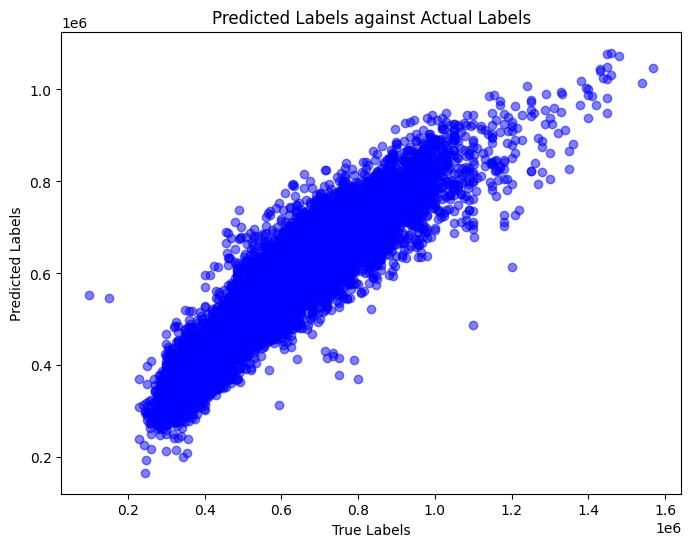

In [ ]:
plot_prediction_results(y_test, y_pred_elastic)

## Decision Tree Regressor

Following the development of multiple features through feature engineering, our objective was to discern the significance of each feature. This prompted us to utilize the Decision Tree Regressor, acclaimed for its interpretability. Employing tree-based regression models allowed us to gain insights into feature importance. However, as our dataset contains more than 190 features and potential overfitting issue might arise, the fundamental Decision Tree algorithm did not yield more satisfactory outcomes as compared to the baseline linear regression model . Consequently, we expanded our exploration to include advanced ensemble techniques. We delved into Random Forest Regressor, LightGBM, and XGBoost to enhance model performance and derive a deeper understanding of feature influence.

In [ ]:
dt_reg = DecisionTreeRegressor(criterion = "squared_error",
                               max_features = 'sqrt',
                               min_samples_leaf = 5,
                               min_samples_split = 3)

In [ ]:
dt_reg.fit(X_train_encoded, y_train)

DecisionTreeRegressor(max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=3)

In [ ]:
y_pred_dt = dt_reg.predict(X_test_encoded)

In [ ]:
decision_tree_results = evaluate_results("Decision Tree Regressor", y_test, y_pred_dt)
collection_of_model_results['Decision Tree Regressor'] = decision_tree_results

Decision Tree Regressor: Mean Absolute Error: 54335.45822994394
Decision Tree Regressor: R-squared score: 0.8078021858180239
Decision Tree Regressor: Root Mean Squared Error: 77951.24293497844
Decision Tree Regressor: Mean Absolute Percentage Error: 8.913309761552476 %


## Random Forest Regressor

In [ ]:
# Hyper Parameter Finetuning on RandomForestRegressor
# model = RandomForestRegressor(oob_score=True, random_state=3, n_jobs=-1)
# params ={
#     'n_estimators': [200, 300, 400, 500, 600, 700],
#     'min_samples_leaf': [1, 2, 3, 5, 10, 25],
#     'max_features': [None, 0.5, 'sqrt', 'log2'],
#     'max_depth': [5, 6, 7, 8, 10, 15, 17, 20],
#     'min_samples_split': [2, 3, 4]
# }

# best_score = 0
# for g in ParameterGrid(params):
#     model.set_params(**g)
#     model.fit(X_train, y_train)
#     if model.oob_score_ > best_score:
#         best_score = model.oob_score_
#         best_grid = g
#         print('oob:', best_score, best_grid)

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, oob_score=True, max_depth=17, min_samples_leaf=4, min_samples_split=2, max_features=0.5)
rf.fit(X_train_encoded, y_train)
rf.oob_score_

0.94821928549647

As mentioned in Decision Tree Regressor, a benefit of RandomForestRegression is that we can view the feature importance of each variable. This gives us a sensing of what variables are more important.

It is very interesting (and unsurprising) to see that the top variables of highest importance are floor_area_sqm, max_floor_lvl, year, flat_type_3_ROOM, year_completed...

The most surprising insight was that `max_floor_lvl` and `shortest_distance_to_closest_mrt (km)` were not features that originally belong to the main HDB resale transaction dataset! It was actually derived from other datasets / API calls from our feature engineering that we decided to use to enhance the number of features of the original HDB resale transactions dataset.

In [ ]:
def rf_feat_importance(m, df, columns):
    return pd.DataFrame({'Feature': columns, 'Importance': m.feature_importances_}).sort_values('Importance', ascending=False)

feat_imp = rf_feat_importance(rf, X_train_encoded, all_column_names).head(10)
feat_imp

,Feature,Importance
1,floor_area_sqm,0.309710
4,max_floor_lvl,0.181987
16,year,0.089611
46,flat_type_3 ROOM,0.078694
5,year_completed,0.047507
49,flat_type_EXECUTIVE,0.024997
2,remaining_lease,0.024882
0,storey_range,0.023684
47,flat_type_4 ROOM,0.022264
3,shortest_distance_to_closest_mrt (km),0.020957


In [ ]:
y_pred_rfr = rf.predict(X_test_encoded)

In [ ]:
random_forest_results = evaluate_results("Random Forest Regressor", y_test, y_pred_rfr)
collection_of_model_results['Random Forest Regressor'] = random_forest_results

Random Forest Regressor: Mean Absolute Error: 35874.32677461611
Random Forest Regressor: R-squared score: 0.9126658380986281
Random Forest Regressor: Root Mean Squared Error: 52546.14994171867
Random Forest Regressor: Mean Absolute Percentage Error: 5.760127271097378 %


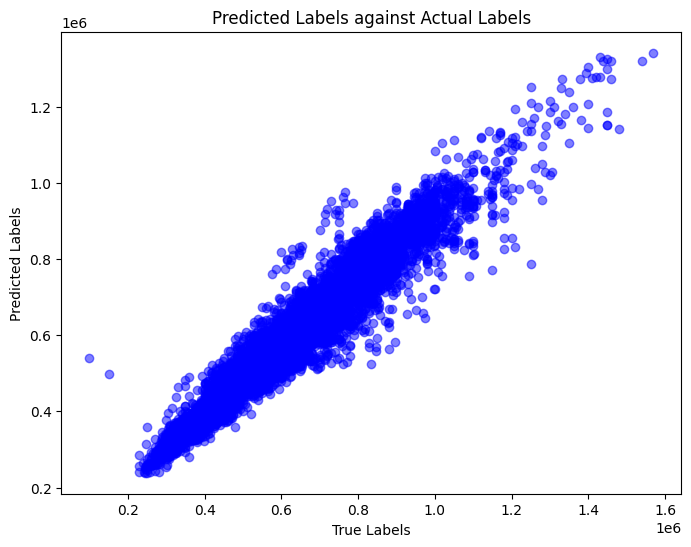

In [ ]:
plot_prediction_results(y_test, y_pred_rfr)

## MultiLayer Perceptron

In this section, we attempt to fit our data into a Simple Multi-Layer Neural Network with ReLU activations using the TensorFlow Library. The input shape will be equal to the total number of encoded features in the training set while the output shape will be a single neuron representing the predicted House Price. The main activation functions across all hidden layers will be ReLU. To also prevent overfitting on the training set, we will be adding Dropout layers with a probability of 0.5.

In [ ]:
# Using TensorFlow's Sequential Neural Network Model Builder
nn = Sequential()

input_shape = (197,)

nn.add(Dense(128, input_shape=input_shape, activation='relu'))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation='linear'))


nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = nn.fit(X_train_encoded.toarray(), y_train, batch_size=32, epochs=25, validation_split=0.3, verbose=2)

Epoch 1/25
3519/3519 - 13s - loss: 22343936000.0000 - mae: 94872.7031 - val_loss: 10770232320.0000 - val_mae: 89708.6719 - 13s/epoch - 4ms/step
Epoch 2/25
3519/3519 - 14s - loss: 6686241280.0000 - mae: 61925.3320 - val_loss: 8983758848.0000 - val_mae: 82197.8672 - 14s/epoch - 4ms/step
Epoch 3/25
3519/3519 - 15s - loss: 6421055488.0000 - mae: 60790.7891 - val_loss: 8049482240.0000 - val_mae: 77551.2578 - 15s/epoch - 4ms/step
Epoch 4/25
3519/3519 - 15s - loss: 6192261120.0000 - mae: 59843.6758 - val_loss: 7803295232.0000 - val_mae: 76090.1016 - 15s/epoch - 4ms/step
Epoch 5/25
3519/3519 - 17s - loss: 5987533824.0000 - mae: 58767.2383 - val_loss: 4317015040.0000 - val_mae: 52895.1445 - 17s/epoch - 5ms/step
Epoch 6/25
3519/3519 - 11s - loss: 5933143552.0000 - mae: 58388.3633 - val_loss: 3206179328.0000 - val_mae: 43454.1055 - 11s/epoch - 3ms/step
Epoch 7/25
3519/3519 - 12s - loss: 5862645760.0000 - mae: 57984.7148 - val_loss: 2757310720.0000 - val_mae: 40163.6523 - 12s/epoch - 3ms/step
Epoc

Lets visualise the training loss and validation loss across the number of iterations. It appears that the validation loss converges rather quickly with a small number of iterations.

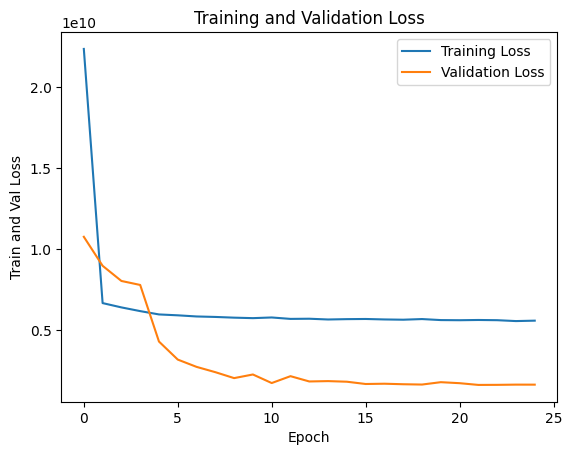

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train and Val Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_nn = nn.predict(X_test_encoded)

439/439 [==============================] - 1s 2ms/step


In [ ]:
nn_results = evaluate_results("Neural Network", y_test, y_pred_nn)
collection_of_model_results['Neural Network'] = nn_results

Neural Network: Mean Absolute Error: 47712.13016458853
Neural Network: R-squared score: 0.8962289569247369
Neural Network: Root Mean Squared Error: 57277.877114695955
Neural Network: Mean Absolute Percentage Error: 9.470080423320903 %


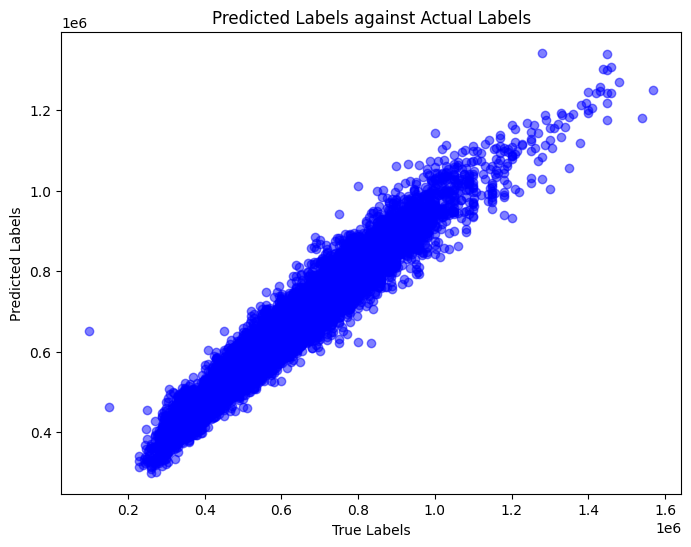

In [ ]:
plot_prediction_results(y_test, y_pred_nn)

## LightGBM

Drawing inspiration from the research paper "Housing Price Prediction via Improved Machine Learning Techniques," we opted to implement the Light Gradient Boosting Machine (LightGBM), a sophisticated gradient boosting framework that harnesses tree-based learning algorithms. Notable for its efficacy and distributed computing capabilities, LightGBM offers several key advantages:

Accelerated training speed paired with enhanced efficiency.

Reduced memory consumption.
Superior accuracy in predictive tasks.

Comprehensive support for parallel, distributed, and GPU learning.

Proficient at managing large-scale data, facilitating the handling of extensive datasets.

Link to API: https://lightgbm.

Link to research paper: readthedocs.io/en/latest/index.html#

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.15],
    'n_estimators': [64, 128],
    'min_child_weight' : [1, 2],
    'reg_lambda': [0.4, 0.45, 0.5],
    'num_leaves': [18, 36, 72],
    'colsample_bytree': [0.7, 0.8]
}

model = LGBMRegressor()

search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(X_train_encoded, y_train)
print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 160858, number of used features: 193
[LightGBM] [Info] Start training from score 486502.012851
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'min_child_weight': 1, 'n_estimators': 128, 'num_leaves': 72, 'reg_lambda': 0.5}


In [ ]:
lgbm = LGBMRegressor(colsample_bytree = 0.8,
                     learning_rate = 0.15,
                     min_child_weight = 1,
                     n_estimators= 128,
                     num_leaves= 72,
                     reg_lambda= 0.5)

lgbm.fit(X_train_encoded, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 160858, number of used features: 193
[LightGBM] [Info] Start training from score 486502.012851


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.15, min_child_weight=1,
              n_estimators=128, num_leaves=72, reg_lambda=0.5)

In [ ]:
y_pred_lgbm = lgbm.predict(X_test_encoded)

In [ ]:
lgbm_results = evaluate_results("LGBM", y_test, y_pred_lgbm)
collection_of_model_results['LGBM'] = lgbm_results

LGBM: Mean Absolute Error: 28049.784372841612
LGBM: R-squared score: 0.950491728304414
LGBM: Root Mean Squared Error: 39562.86235936871
LGBM: Mean Absolute Percentage Error: 4.695477475121855 %


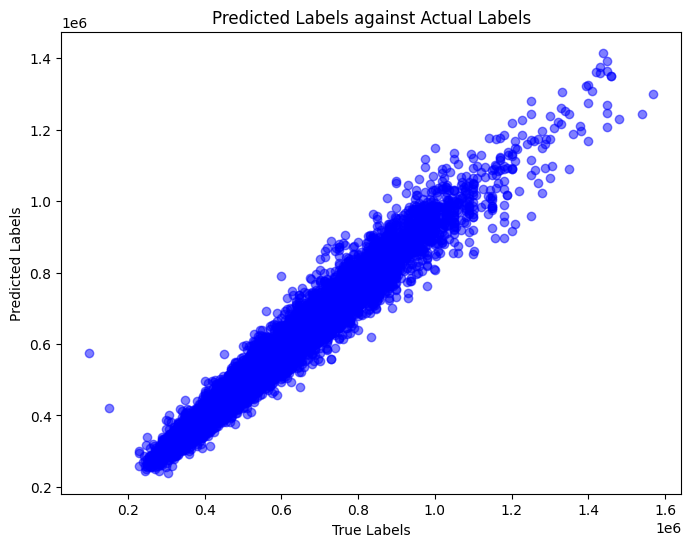

In [ ]:
plot_prediction_results(y_test, y_pred_lgbm)

In [ ]:
feature_importance = lgbm.feature_importances_

lgbm_fi = pd.DataFrame({'Feature': all_column_names, 'Importance': feature_importance})
lgbm_fi = lgbm_fi.sort_values(by='Importance', ascending=False).iloc[:10,] # Filter top 10 features
lgbm_fi

,Feature,Importance
1,floor_area_sqm,1060
3,shortest_distance_to_closest_mrt (km),811
5,year_completed,690
2,remaining_lease,541
4,max_floor_lvl,501
12,total_dwelling_units,463
16,year,461
0,storey_range,241
20,town_BISHAN,106
13,is_elite_closest_pri_sch,106


## XGBoost

Motivated by the insights from the research paper titled "Housing Price Prediction via Improved Machine Learning Techniques," we elected to incorporate Extreme Gradient Boosting (XGBoost). XGBoost is an optimized distributed gradient boosting library, renowned for its efficiency, flexibility, and portability. Employing a level-wise growth strategy, XGBoost methodically processes all possible splits at a current depth before progressing to the next, ensuring a balanced tree structure.

In the course of our project, XGBoost has not only outperformed LightGBM in terms of evaluation metrics, potentially due to LightGBM's overfitting issues with a substantial number of encoded features, but it has also demonstrated greater speed relative to Random Forest thanks to its innovative approach to handling sparse data. Nevertheless, consistent with the observations in the research paper, XGBoost's level-wise expansion does result in slower training times when compared to LightGBM.

Link to algorithm:https://creativecommons.org/licenses/by-nc-nd/4.0/

Link to research paper:https://xgboost.readthedocs.io/en/stable/index.html


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2],
    'subsample': [1],
    'colsample_bytree' : [0.6, 0.8],
    'reg_lambda': [0.45],
    'gamma': [0.3, 0.4, 0.5]
}

xgbr = xgb.XGBRegressor()

search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
search.fit(X_train_encoded, y_train)
print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.2, 'min_child_weight': 2, 'n_estimators': 300, 'reg_lambda': 0.45, 'subsample': 1}


In [ ]:
xgbr = xgb.XGBRegressor(
    colsample_bytree=0.8,
    gamma=0.3,
    learning_rate=0.2,
    min_child_weight=2,
    n_estimators=300,
    reg_lambda=0.45,
    subsample=1
)

xgbr.fit(X_train_encoded, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_xgb = xgbr.predict(X_test_encoded)

In [ ]:
xgbr_results = evaluate_results("XGBR", y_test, y_pred_xgb)
collection_of_model_results['XGBR'] = xgbr_results

XGBR: Mean Absolute Error: 27568.409085500534
XGBR: R-squared score: 0.9536627662968679
XGBR: Root Mean Squared Error: 38274.883183916645
XGBR: Mean Absolute Percentage Error: 4.6591122275074035 %


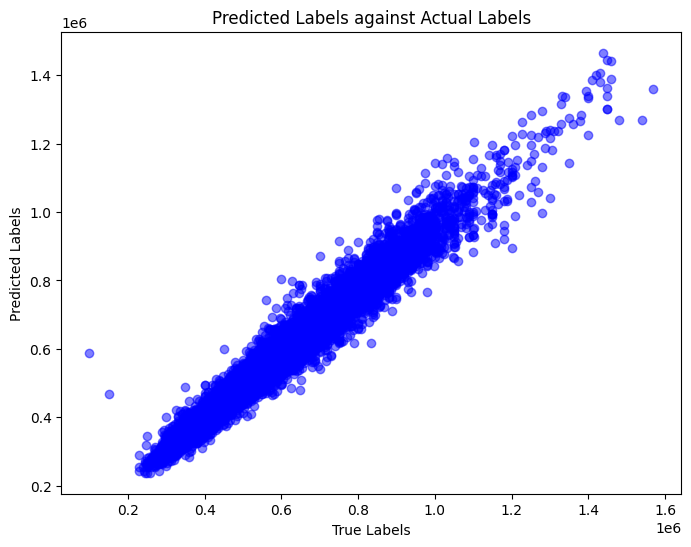

In [ ]:
plot_prediction_results(y_test, y_pred_xgb)

It is very interesting to see that the XGBR Model did not even have the "floor_area_sqm" as a top 10 feature, in terms of importance. This is unlike the Random Forest Regressor and Light GBM Models.

In [ ]:
feature_importance = xgbr.feature_importances_

xgbr_fi = pd.DataFrame({'Feature': all_column_names, 'Importance': feature_importance})
xgbr_fi = xgbr_fi.sort_values(by='Importance', ascending=False).iloc[:10,] # Filter top 10
xgbr_fi

,Feature,Importance
49,flat_type_EXECUTIVE,0.082093
46,flat_type_3 ROOM,0.080903
20,town_BISHAN,0.043640
4,max_floor_lvl,0.033104
38,town_SENGKANG,0.031149
45,flat_type_2 ROOM,0.030712
23,town_BUKIT PANJANG,0.028180
22,town_BUKIT MERAH,0.027295
69,flat_model_Terrace,0.025170
48,flat_type_5 ROOM,0.024912


## Analysing all Model Results

The Top 2 best performing madels are the Gradient Boosting Models LGBM and XGBR, with an average Mean Absolute Error of 28049 and 27568 respectively. When compared to the average resale price of the HDB Flats, this error makes up a small proportion of the price of each Flat. This can be compared to the mean value of each resale flat across all the transactions in the test dataset - which is $582082. We can also look at the Mean Absolute Percentage Error to see that the error only makes up a small percentage (4.7%) of the actual value.

It is surprising to see that The Neural Network model have approximately the same performance as compared to the baseline regression models. This metric could benefit from further optimisation.

In [ ]:
pd.DataFrame.from_dict({(j): collection_of_model_results[i][j] for i in collection_of_model_results.keys() for j in collection_of_model_results[i].keys()}, orient='index')

,Mean Absolute Error,R-squared score,Root Mean Squared Error,Mean Absolute Percentage Error
Linear Regression,48455.090761,0.864575,65433.198636,8.253610
Random Forest Regressor,35982.440512,0.911841,52793.726633,5.772779
L2 Linear Regression (Ridge),48476.536298,0.864473,65457.789903,8.252991
L1 Linear Regression (Lasso),48474.960339,0.864517,65447.173527,8.253311
Neural Network,47712.130165,0.896229,57277.877115,9.470080
LGBM,28049.784373,0.950492,39562.862359,4.695477
XGBR,27568.409086,0.953663,38274.883184,4.659112
Elastic Net Regression,56420.772178,0.782576,82909.157902,8.995243
Decision Tree Regressor,54335.458230,0.807802,77951.242935,8.913310


In [ ]:
df_test['resale_price'].mean()

582082.2950936944

## Comparing Feature Importance across the Tree Models

The 3 different 3 models (XGBR, Light GBM, and Random Forest Regressor) have placed different importance on different Features. It is interesting to note that the important features of the LGBM Model are very similar to that of the Random Forest Model. The similar top feature importance variables across these 2 models are floor_area_sqm, max_floor_lvl, storey_range, year and remaining_lease. On the other hand, XGBR tends to place a lot more emphasis on the categorical data, which has been one-hot-encoded. For instance, flat type and town were one hot encoded features that dominated in the feature importance list for XGBR. The variation in important features may be attributed to the high correlation between flat type and floor area. For example, a four-room flat typically has a larger floor area compared to a one-room flat. Thus, we still consider the floor area to be a significant factor in the context of this project.

In [ ]:
from IPython.display import display

display(feat_imp, lgbm_fi, xgbr_fi)

,Feature,Importance
1,floor_area_sqm,0.296129
4,max_floor_lvl,0.180538
16,year,0.089778
46,flat_type_3 ROOM,0.084105
5,year_completed,0.047846
47,flat_type_4 ROOM,0.027011
49,flat_type_EXECUTIVE,0.026267
2,remaining_lease,0.025912
0,storey_range,0.025539
3,shortest_distance_to_closest_mrt (km),0.020494


,Feature,Importance
1,floor_area_sqm,1060
3,shortest_distance_to_closest_mrt (km),811
5,year_completed,690
2,remaining_lease,541
4,max_floor_lvl,501
12,total_dwelling_units,463
16,year,461
0,storey_range,241
20,town_BISHAN,106
13,is_elite_closest_pri_sch,106


,Feature,Importance
49,flat_type_EXECUTIVE,0.082093
46,flat_type_3 ROOM,0.080903
20,town_BISHAN,0.043640
4,max_floor_lvl,0.033104
38,town_SENGKANG,0.031149
45,flat_type_2 ROOM,0.030712
23,town_BUKIT PANJANG,0.028180
22,town_BUKIT MERAH,0.027295
69,flat_model_Terrace,0.025170
48,flat_type_5 ROOM,0.024912


## Hybridise Regression

Lets attempt to aggregate the regression predictions from the top 2 models (XGBR and LGBM) and analyse whether the ensemble of these 2 models results in a better performance.

In [ ]:
y_pred_hybrid = (np.array(y_pred_xgb) + np.array(y_pred_lgbm)) / 2

In [ ]:
hybrid_results = evaluate_results("LGBM + XGBRS", y_test, y_pred_hybrid)

LGBM + XGBRS: Mean Absolute Error: 27144.774272233914
LGBM + XGBRS: R-squared score: 0.9543239335450038
LGBM + XGBRS: Root Mean Squared Error: 38000.837696084134
LGBM + XGBRS: Mean Absolute Percentage Error: 4.55458475653832 %


It is very interesting to note that the average of the predictions from LGBM and XGBR resulted in a slightly better MAE as compared to the individual models. The LGBM individual model had a MAE of 28049 and XGBR had a MAE of 27568.

In [ ]:
pd.DataFrame(hybrid_results)

,LGBM + XGBRS
Mean Absolute Error,27144.774272
Mean Absolute Percentage Error,4.554585
R-squared score,0.954324
Root Mean Squared Error,38000.837696


# Conclusions




This project placed a lot of emphasis in creating a robust feature engineering strategy to generate meaningful features to improve our model performances. This is evident from the feature importance analysis which had displayed some features which were not originally present in the Transactions dataset. Importance features like shortest_distance_to_closest_mrt (km), is_elite_closest_pri_sch, year_completed were either generated from feature engineering or found from external datasets.  


When initially exploring the use of baseline models, these models perform sufficiently well with a acceptable MAE of approximately 50000. We also noted that the performance of our Neural Network was almost similar to the performance of the baseline regression models (Linear Regression, Decision Tree Regressor). This was a shock to us as we had even attempted to reduce overfitting using Dropout Layers.


Given that our preprocessed dataset comprised over 190 features, this high dimensionality likely introduced additional noise and complexity, exacerbating the non-ensemble models' tendencies to overfit. Recognising these challenges, we dedicated further efforts to investigate and implement more complex techniques such as Random Forest Regressor, LightGBM and XGBoost to make much more accurate predictions.

We also explored the use of further ensembling the predictions of both of our top models and found that the Hybridised model had a better performance as compared to the individual models. This was a quick and simple way for us to make better predictions by ensembling the best models together.
